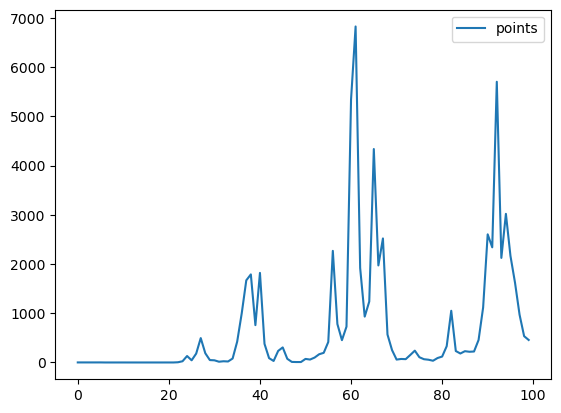

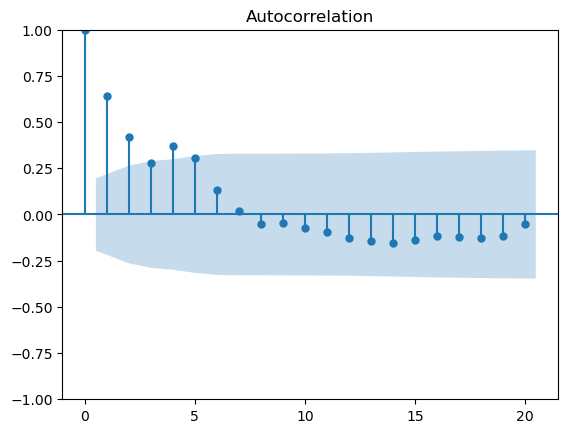

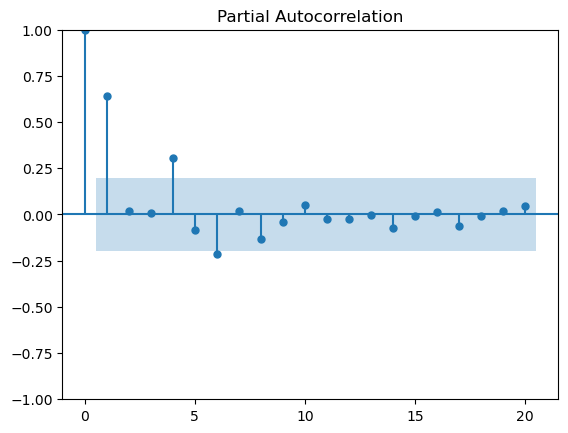

In [44]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
import numpy as np

test_with_artificial = True

def artificial_arima(p=np.array([]), d=0, q = np.array([]), f=lambda x:x, n = 100):
    # generate synthetic data in order to validate our method for real data
    a  = np.random.normal(0,1,n)
    W = np.zeros(n)
    for t in range(n):   
        if t < len(p) and t < len(q):
            W[t] = 0# maybe this can be done cleaner but whatever
        else:
            W[t] = - W[t-len(p):t] @ p + a[t] + a[t-len(q):t] @ p 
    
    for d_c in range(d):
        W = np.cumsum(W) 
        
        
    return f(W)
    
    


if test_with_artificial:
    points = artificial_arima(
        p = np.array([0,0,0,0,.1]),
        q = np.array([0,0,0,0,.1]),
        d = 1,
        f = np.exp,
        n = 100
    )
    time_series_df = pd.DataFrame({'points': points})
else:
    # Load the CSV file
    data = pd.read_csv('EUR_USD_monthly.csv')
    
    # Extract the time and price series
    time = pd.to_datetime(data.iloc[:, 0])  # Assuming first column is 'time'
    prices = data.iloc[:, 1].replace(',', '', regex=True).astype(float)  # Remove commas and convert to float
    
    
    # Create a DataFrame with the time and prices
    time_series_df = pd.DataFrame({'time': time, 'points': prices})
    time_series_df.set_index('time', inplace=True)

def plot_series(series):
    # Plot the time series using Plotly
    series.plot()
    
    plot_acf(series)
    plot_pacf(series)
plot_series(time_series_df)


Test stationarity, Augmented Dickey-Fuller unit root test.

In [45]:
#Check stationarity
# alternative hypothesis is stationarity 
st.adfuller(time_series_df['points'])


(-3.112842898480669,
 0.025617240466935844,
 5,
 94,
 {'1%': -3.5019123847798657,
  '5%': -2.892815255482889,
  '10%': -2.583453861475781},
 1451.7747975082175)

p value > 0.05 => we can not conclude stationarity

apply box cox transformation, and use scipy to estimate optimal box cox parameter lambda (todo explain what method scipy uses)

Optimal lambda:  0.14385486529681896


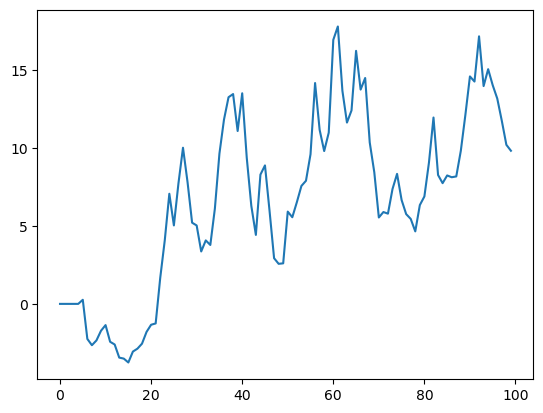

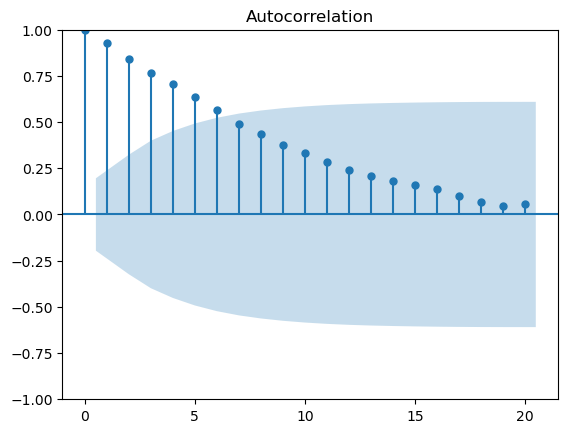

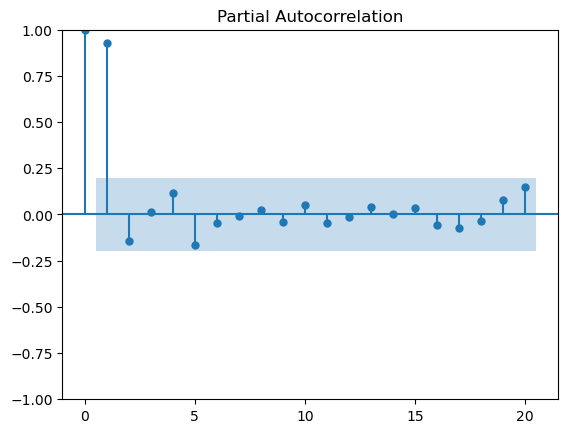

In [46]:
from scipy import stats


# Apply Box-Cox transformation and estimate lambda
transformed_prices, lambda_est = stats.boxcox(time_series_df["points"])

# Store the transformed values back into the DataFrame
time_series_df['boxcox_points'] = transformed_prices

plot_series(time_series_df['boxcox_points'])

print("Optimal lambda: ", lambda_est)

Differentiate and see when stationarity tests become positive

In [19]:
alpha = 0.05

        

# Assuming 'time_series_df' is your DataFrame and 'Prices' is the column
current_series = time_series_df['points'] # todo possible bug, try with_: pd.DataFrame(np.random.random(100))#np.exp(time_series_df['boxcox_points'])
differencing_count = 0

# Function to apply ADF test and get p-value
def get_adf_p_value(series):
    adf_result = st.adfuller(series.dropna())
    return adf_result[1]  # Return p-value from ADF test

# Keep iterating until the series is stationary or we reach the max differencing
while get_adf_p_value(current_series) >= alpha:
    differencing_count += 1
    # Apply first-order differencing
    current_series = current_series.diff()

    # Add the differenced series to the DataFrame
    time_series_df[f'diff_prices_{differencing_count}'] = current_series
    print("defferentiation")
    # Print progress with the p-value after differencing
    print(f"After {differencing_count} differencing(s), the ADF p-value is: {get_adf_p_value(current_series)}")


# Check if series is stationary after differencing
if get_adf_p_value(current_series) < alpha:
    print(f"Series is stationary after {differencing_count} differencings.")
    print("")
else:
    print("Max differencings reached without achieving stationarity.")





defferentiation
After 1 differencing(s), the ADF p-value is: 1.2426670145880777e-08
Series is stationary after 1 differencings.



Plot the new time series and acf and pcf

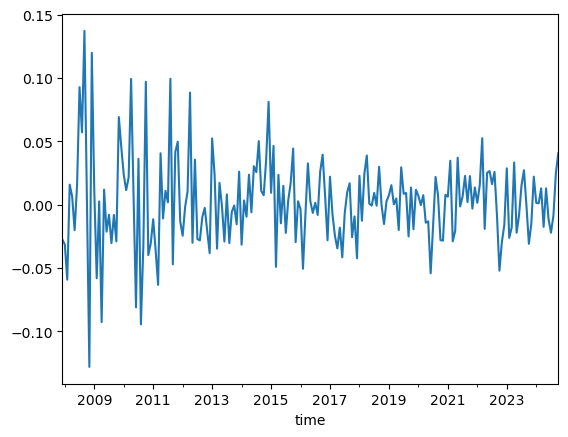

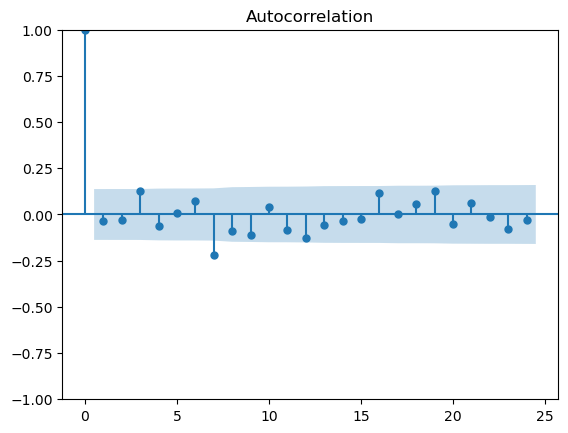

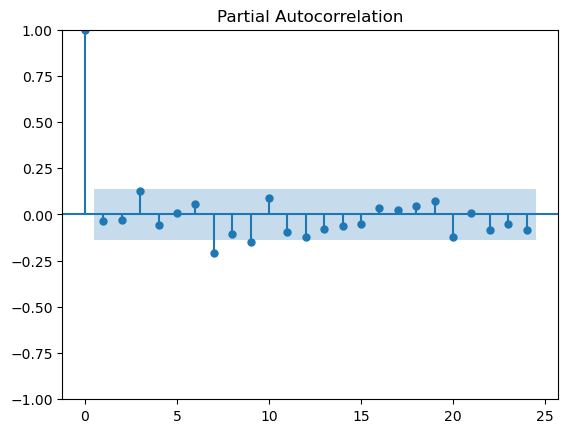

In [20]:
plot_series(time_series_df[f'diff_prices_{differencing_count}'].dropna())


Print significant auto and partial autocorelations

In [9]:
print(st.acf(time_series_df[f'diff_prices_{differencing_count}'].dropna(), qstat=True))

(array([ 1.00000000e+00, -2.58052122e-02,  4.92727658e-02, -8.43892669e-02,
       -8.37525275e-04,  4.80410655e-04,  3.92600980e-02, -5.98751250e-02,
        1.58545369e-02, -2.49498077e-02, -1.47486106e-02,  6.50673874e-03,
       -5.51573090e-02,  6.89092687e-02,  9.56664387e-03,  2.47809685e-02,
       -2.47911024e-03, -1.15604043e-02, -2.76424626e-02,  4.78626720e-03,
        2.58253350e-02, -4.32009191e-04,  6.19830737e-02, -2.80291887e-03,
       -1.96509034e-02, -1.57520503e-02,  1.51114551e-02, -4.17165025e-02,
       -1.81460673e-02, -4.40584552e-02,  1.63072990e-03,  5.40603160e-02]), array([ 0.86701503,  4.0304605 , 13.31704199, 13.3179574 , 13.31825882,
       15.33286741, 20.02226223, 20.35131635, 21.16682983, 21.45202078,
       21.50757248, 25.50254725, 31.74277961, 31.86314525, 32.67141807,
       32.67951372, 32.85568879, 33.863759  , 33.89400517, 34.77527282,
       34.77551962, 39.85994372, 39.87034907, 40.38219742, 40.7113454 ,
       41.0145045 , 43.32664978, 43.7